# CIFAR10 with CNNs

## Imports

Scores do modelo original:

 {'accuracy': 0.7136, 'balanced_accuracy': np.float64(0.7136000000000001), 'precision': 0.7141355730287995, 'recall': 0.7136, 'f1_score': 0.7133133029149751}

In [8]:
#@title Libs

import torch
import torchvision
from torchvision.datasets import CIFAR10
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from  torch.utils.data import DataLoader, Subset

import matplotlib.pyplot as plt
import numpy as np

from sklearn import metrics
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tqdm import tqdm

## Dataset setup sem augmentation

In [49]:
#@title Dataset Setup

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [50]:
train_val_dataset = CIFAR10(root='./data', train=True,
                                        download=True,  transform=transform)

test_dataset = CIFAR10(root='./data', train=False,
                                        download=True,  transform=transform)

classes = test_dataset.classes

Gera val_dataset como subset balanceado de train_val_dataset


In [51]:
# Extrai os rótulos
targets = np.array(train_val_dataset.targets)

# Cria o validador estratificado
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Gera os índices
for train_idx, val_idx in splitter.split(np.zeros(len(targets)), targets):
    train_dataset = Subset(train_val_dataset, train_idx)
    val_dataset = Subset(train_val_dataset, val_idx)

In [52]:
def makeLoaders(batch_size):
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

## Data Augmentation

In [17]:
# Define as transformações
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

val_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_val_dataset_aug = CIFAR10(root='./data', train=True, download=False, transform=train_transform)
train_val_dataset_plain = CIFAR10(root='./data', train=True, download=False, transform=val_test_transform)

# Extrai os rótulos
targets = np.array(train_val_dataset_plain.targets)

# Cria o validador estratificado
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Gera os índices
for train_idx, val_idx in splitter.split(np.zeros(len(targets)), targets):
    train_dataset_aug = Subset(train_val_dataset_aug, train_idx)     # com augmentation
    val_dataset = Subset(train_val_dataset_plain, val_idx)       # sem augmentation

# Dataset de teste também sem augmentation
test_dataset = CIFAR10(root='./data', train=False, download=False, transform=val_test_transform)

## Visualizar imagens

In [7]:
def imshow(img):
    img = img / 2 + 0.5     # desnormalizar
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

In [8]:
# Encontrar uma imagem de cada classe
images_per_class = {}
# Itera sobre o dataset até encontrar uma imagem para cada uma das 10 classes
for img, label in test_dataset:
    class_name = classes[label]
    if class_name not in images_per_class:
        images_per_class[class_name] = img
    # Para de procurar quando já tiver uma imagem de cada classe
    if len(images_per_class) == len(classes):
        break

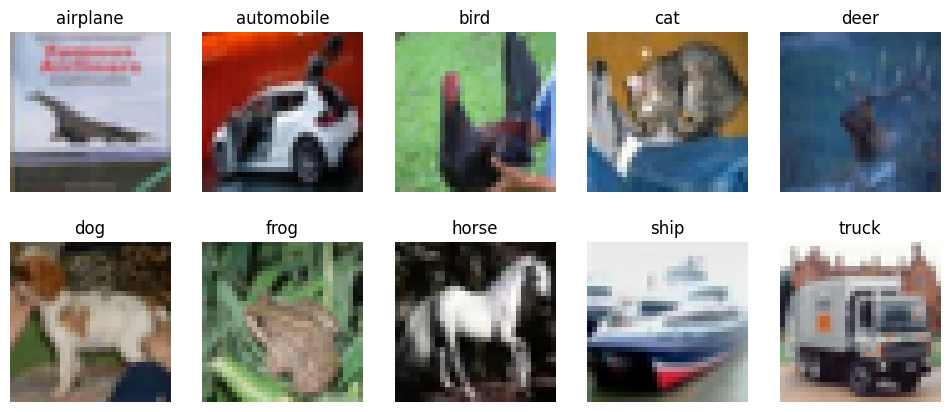

In [9]:
# Criar uma figura para exibir as imagens
fig = plt.figure(figsize=(12, 5))

# Exibe uma imagem para cada classe
for i, class_name in enumerate(classes):
    ax = fig.add_subplot(2, 5, i + 1) # Cria uma grade 2x5 de subplots
    ax.set_title(class_name)
    imshow(images_per_class[class_name])

plt.show()

## Defining the CNN model

In [16]:
class FlexibleCNN(nn.Module):
    """
    Uma CNN flexível com pooling opcional após cada camada convolucional.
    Espera imagens de 3 canais com 32x32 pixels.
    """
    def __init__(self, config):
        super(FlexibleCNN, self).__init__()
        self.config = config

        initial_in_channels = 3
        img_height = 32
        img_width = 32

        # 1. Camadas de extração de características
        features_layers = []
        in_channels = initial_in_channels

        for conv_config in self.config['conv_layers']:
            # Suporte a tuplas com ou sem 'use_pool'
            if len(conv_config) == 4:
                out_channels, k, s, p = conv_config
                use_pool = False
            elif len(conv_config) == 5:
                out_channels, k, s, p, use_pool = conv_config
            else:
                raise ValueError("Cada entrada de 'conv_layers' deve ter 4 ou 5 elementos.")

            features_layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=k, stride=s, padding=p))
            features_layers.append(nn.ReLU())

            if use_pool:
                features_layers.append(nn.MaxPool2d(
                    kernel_size=self.config['pool_kernel_size'],
                    stride=self.config.get('pool_stride', self.config['pool_kernel_size'])
                ))

            in_channels = out_channels

        self.features = nn.Sequential(*features_layers)

        # 2. Calcular o tamanho da saída do extrator de features
        with torch.no_grad():
            dummy_input = torch.zeros(1, initial_in_channels, img_height, img_width)
            dummy_output = self.features(dummy_input)
            self.flattened_features_size = dummy_output.view(-1).shape[0]

        # 3. Camadas totalmente conectadas
        classifier_layers = []
        in_features = self.flattened_features_size

        for out_features, dropout_rate in self.config.get('fc_layers', []):
            classifier_layers.append(nn.Linear(in_features, out_features))
            classifier_layers.append(nn.ReLU())
            if dropout_rate > 0:
                classifier_layers.append(nn.Dropout(p=dropout_rate))
            in_features = out_features

        classifier_layers.append(nn.Linear(in_features, self.config['output_size']))
        self.classifier = nn.Sequential(*classifier_layers)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


## Evaluation helper functions

In [2]:
#@title Defining metrics helper

def get_scores(targets, predictions):
    return {
        "accuracy": metrics.accuracy_score(targets, predictions),
        "balanced_accuracy": metrics.balanced_accuracy_score(targets, predictions),
        "precision": metrics.precision_score(targets, predictions, average="weighted"),
        "recall": metrics.recall_score(targets, predictions, average="weighted"),
        "f1_score": metrics.f1_score(targets, predictions, average="weighted")
    }

In [3]:
def evaluate(net, loader, loss_function):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    net.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            loss = loss_function(outputs, labels)
            val_loss += loss.item()
    net.train()
    return val_loss / len(loader)

In [4]:
#@title Evaluate model (accuracy, precision, recall, etc)

def makePredictions(net, test_loader):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  net.eval()
  predictions = []
  labels = []
  for images, label in test_loader:
    images = images.to(device)
    label = label.to(device)

    output = net(images)
    _, predicted = torch.max(output,1)

    predictions.extend(predicted.cpu().numpy())
    labels.extend(label.cpu().numpy())

  return labels, predictions

In [5]:
def plotLoss(train_losses, val_losses):
    plt.plot(train_losses, label='Treinamento')
    plt.plot(val_losses, label='Validação')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.title('Loss de Treinamento e Validação')
    plt.legend()
    plt.grid(True)
    plt.show()

## Train Loop

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(net, train_loader, val_loader, criterion, optimizer, device, num_epochs=20, patience=3):
    net.to(device)

    train_losses = []
    val_losses = []

    best_loss = float('inf')
    best_model_state = None
    patience_counter = 0

    for epoch in tqdm(range(num_epochs)):
        net.train()
        epoch_loss = 0.0

        for i, (inputs, labels) in enumerate(train_loader, 0):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            if (i + 1) % 1000 == 0:
              tqdm.write(f'Epoch {epoch + 1}/{num_epochs}, Step {i + 1}/{len(train_loader)}, Loss: {loss:.4f}')

        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validação
        net.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        tqdm.write(f'Epoch {epoch+1} completed. Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}')

        # Early stopping
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            best_model_state = net.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                tqdm.write(f"Early stopping at epoch {epoch+1}")
                break

    # Restaura melhor modelo encontrado
    if best_model_state is not None:
        net.load_state_dict(best_model_state)

    return net, train_losses, val_losses

## Experiment 1

Usa a mesma arquitetura do projeto original mas separa o conjunto de treino do CIFAR10 em treino e validação. O conjunto de validação é usado para a técnica de early stopping durante o treinamento.

In [16]:
#@title Hyperparameters

learning_rate = 0.001
num_epochs = 50
batch_size = 32
patience = 5

In [17]:
train_loader, val_loader, test_loader = makeLoaders(batch_size)

In [18]:
config1 = {
    'conv_layers': [
        (32, 3, 1, 1, True),
        (64, 3, 1, 1, True)
    ],
    'pool_kernel_size': 2,
    'pool_stride': 2,
    'fc_layers': [
        (120, 0.0),
        (84, 0.0)
    ],
    'output_size': 10
}

# Criando o modelo
model1 = FlexibleCNN(config1)

In [19]:
optimizer = optim.Adam(model1.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

trained_CNN, train_losses, val_losses = train_model(model1,
                                                    train_loader,
                                                    val_loader,
                                                    criterion,
                                                    optimizer,
                                                    device,
                                                    num_epochs,
                                                    patience)

  0%|          | 0/50 [00:17<?, ?it/s]

Epoch 1/50, Step 1000/1250, Loss: 1.0847


  2%|▏         | 1/50 [00:26<21:27, 26.27s/it]

Epoch 1 completed. Train Loss: 1.3818 | Val Loss: 1.1235


  2%|▏         | 1/50 [00:43<21:27, 26.27s/it]

Epoch 2/50, Step 1000/1250, Loss: 0.6318


  4%|▍         | 2/50 [00:51<20:27, 25.57s/it]

Epoch 2 completed. Train Loss: 0.9913 | Val Loss: 0.9895


  4%|▍         | 2/50 [01:07<20:27, 25.57s/it]

Epoch 3/50, Step 1000/1250, Loss: 0.9587


  6%|▌         | 3/50 [01:16<19:50, 25.33s/it]

Epoch 3 completed. Train Loss: 0.8217 | Val Loss: 0.8844


  6%|▌         | 3/50 [01:33<19:50, 25.33s/it]

Epoch 4/50, Step 1000/1250, Loss: 0.4812


  8%|▊         | 4/50 [01:41<19:12, 25.05s/it]

Epoch 4 completed. Train Loss: 0.7038 | Val Loss: 0.8535


  8%|▊         | 4/50 [01:56<19:12, 25.05s/it]

Epoch 5/50, Step 1000/1250, Loss: 0.7709


 10%|█         | 5/50 [02:05<18:35, 24.78s/it]

Epoch 5 completed. Train Loss: 0.5957 | Val Loss: 0.9403


 10%|█         | 5/50 [02:21<18:35, 24.78s/it]

Epoch 6/50, Step 1000/1250, Loss: 0.7013


 12%|█▏        | 6/50 [02:30<18:10, 24.79s/it]

Epoch 6 completed. Train Loss: 0.5004 | Val Loss: 0.8795


 12%|█▏        | 6/50 [02:46<18:10, 24.79s/it]

Epoch 7/50, Step 1000/1250, Loss: 0.6888


 14%|█▍        | 7/50 [02:55<17:58, 25.07s/it]

Epoch 7 completed. Train Loss: 0.4138 | Val Loss: 0.9305


 14%|█▍        | 7/50 [03:12<17:58, 25.07s/it]

Epoch 8/50, Step 1000/1250, Loss: 0.2996


 16%|█▌        | 8/50 [03:21<17:41, 25.27s/it]

Epoch 8 completed. Train Loss: 0.3401 | Val Loss: 1.0136


 16%|█▌        | 8/50 [03:38<17:41, 25.27s/it]

Epoch 9/50, Step 1000/1250, Loss: 0.1819


 16%|█▌        | 8/50 [03:47<19:54, 28.44s/it]

Epoch 9 completed. Train Loss: 0.2706 | Val Loss: 1.1412
Early stopping at epoch 9


## Experiment 1 results

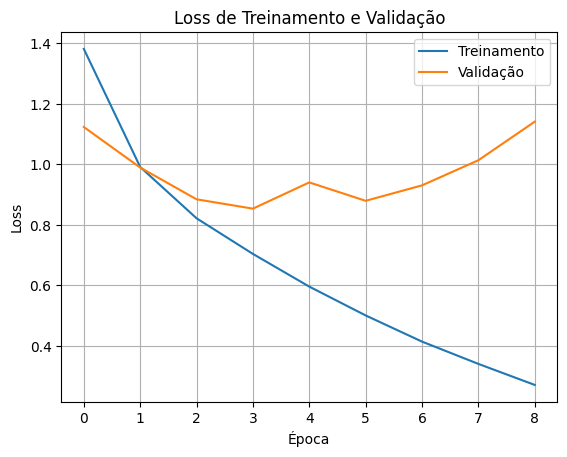

In [20]:
plotLoss(train_losses, val_losses)

In [21]:
torch.save(model1.state_dict(), "model1_trained2.pth")

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model1 = FlexibleCNN(config1)
model1.to(device)

model1.load_state_dict(torch.load("model1_trained.pth", weights_only=True))

<All keys matched successfully>

In [23]:
#@title Evaluate model (accuracy, precision, recall, etc)
labels, predictions = makePredictions(model1, test_loader)

scores = get_scores(labels, predictions)
print("Scores of your model\n", scores)

Scores of your model
 {'accuracy': 0.6834, 'balanced_accuracy': 0.6834, 'precision': 0.6817896719656583, 'recall': 0.6834, 'f1_score': 0.6813534982457458}


Scores of your model
 {'accuracy': 0.6834, 'balanced_accuracy': 0.6834, 'precision': 0.6817896719656583, 'recall': 0.6834, 'f1_score': 0.6813534982457458}


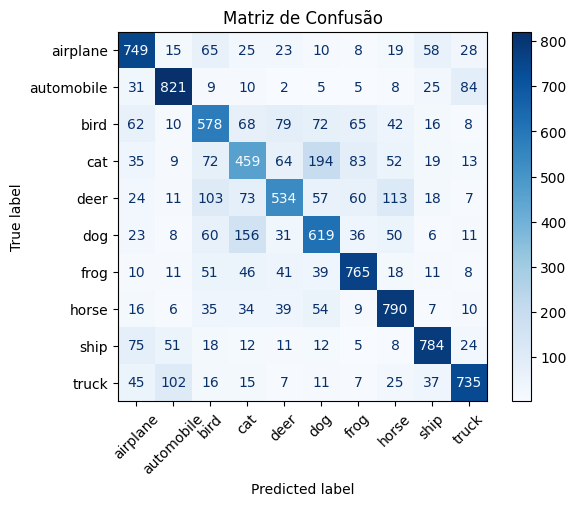

In [24]:
# Lista com nomes das classes (exemplo para CIFAR-10)
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

cm = confusion_matrix(labels, predictions)

# Plotar a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)  # pode mudar o colormap se quiser
plt.title("Matriz de Confusão")
plt.show()

## Experiment 2

Diminuir o learning rate para 0.0001

In [15]:
learning_rate = 0.0001
num_epochs = 50
batch_size = 32
patience = 5

train_loader, val_loader, test_loader = makeLoaders(batch_size)

In [16]:
config1 = {
    'conv_layers': [
        (32, 3, 1, 1, True),
        (64, 3, 1, 1, True)
    ],
    'pool_kernel_size': 2,
    'pool_stride': 2,
    'fc_layers': [
        (120, 0.0),
        (84, 0.0)
    ],
    'output_size': 10
}

# Criando o modelo
model2 = FlexibleCNN(config1)

optimizer = optim.Adam(model2.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [17]:
trained_CNN, train_losses, val_losses = train_model(model2,
                                                    train_loader,
                                                    val_loader,
                                                    criterion,
                                                    optimizer,
                                                    device,
                                                    num_epochs,
                                                    patience)

  0%|          | 0/50 [00:12<?, ?it/s]

Epoch 1/50, Step 1000/1250, Loss: 1.5811


  2%|▏         | 1/50 [00:17<14:33, 17.83s/it]

Epoch 1 completed. Train Loss: 1.7610 | Val Loss: 1.5436


  2%|▏         | 1/50 [00:29<14:33, 17.83s/it]

Epoch 2/50, Step 1000/1250, Loss: 1.3359


  4%|▍         | 2/50 [00:34<13:49, 17.29s/it]

Epoch 2 completed. Train Loss: 1.4540 | Val Loss: 1.3899


  4%|▍         | 2/50 [00:45<13:49, 17.29s/it]

Epoch 3/50, Step 1000/1250, Loss: 1.2491


  6%|▌         | 3/50 [00:51<13:23, 17.09s/it]

Epoch 3 completed. Train Loss: 1.3465 | Val Loss: 1.3112


  6%|▌         | 3/50 [01:03<13:23, 17.09s/it]

Epoch 4/50, Step 1000/1250, Loss: 1.4880


  8%|▊         | 4/50 [01:08<13:06, 17.09s/it]

Epoch 4 completed. Train Loss: 1.2668 | Val Loss: 1.2551


  8%|▊         | 4/50 [01:19<13:06, 17.09s/it]

Epoch 5/50, Step 1000/1250, Loss: 0.7146


 10%|█         | 5/50 [01:25<12:47, 17.05s/it]

Epoch 5 completed. Train Loss: 1.2023 | Val Loss: 1.1940


 10%|█         | 5/50 [01:37<12:47, 17.05s/it]

Epoch 6/50, Step 1000/1250, Loss: 0.9474


 12%|█▏        | 6/50 [01:42<12:30, 17.05s/it]

Epoch 6 completed. Train Loss: 1.1465 | Val Loss: 1.1402


 12%|█▏        | 6/50 [01:54<12:30, 17.05s/it]

Epoch 7/50, Step 1000/1250, Loss: 0.8789


 14%|█▍        | 7/50 [01:59<12:15, 17.10s/it]

Epoch 7 completed. Train Loss: 1.0930 | Val Loss: 1.1132


 14%|█▍        | 7/50 [02:11<12:15, 17.10s/it]

Epoch 8/50, Step 1000/1250, Loss: 0.9707


 16%|█▌        | 8/50 [02:16<11:54, 17.01s/it]

Epoch 8 completed. Train Loss: 1.0452 | Val Loss: 1.0843


 16%|█▌        | 8/50 [02:28<11:54, 17.01s/it]

Epoch 9/50, Step 1000/1250, Loss: 0.6057


 18%|█▊        | 9/50 [02:33<11:38, 17.03s/it]

Epoch 9 completed. Train Loss: 1.0034 | Val Loss: 1.0469


 18%|█▊        | 9/50 [02:45<11:38, 17.03s/it]

Epoch 10/50, Step 1000/1250, Loss: 1.3411


 20%|██        | 10/50 [02:50<11:21, 17.04s/it]

Epoch 10 completed. Train Loss: 0.9646 | Val Loss: 1.0307


 20%|██        | 10/50 [03:02<11:21, 17.04s/it]

Epoch 11/50, Step 1000/1250, Loss: 0.9521


 22%|██▏       | 11/50 [03:07<11:02, 16.98s/it]

Epoch 11 completed. Train Loss: 0.9273 | Val Loss: 0.9976


 22%|██▏       | 11/50 [03:18<11:02, 16.98s/it]

Epoch 12/50, Step 1000/1250, Loss: 0.6940


 24%|██▍       | 12/50 [03:24<10:44, 16.96s/it]

Epoch 12 completed. Train Loss: 0.8947 | Val Loss: 0.9962


 24%|██▍       | 12/50 [03:35<10:44, 16.96s/it]

Epoch 13/50, Step 1000/1250, Loss: 0.7141


 26%|██▌       | 13/50 [03:41<10:26, 16.94s/it]

Epoch 13 completed. Train Loss: 0.8645 | Val Loss: 0.9651


 26%|██▌       | 13/50 [03:52<10:26, 16.94s/it]

Epoch 14/50, Step 1000/1250, Loss: 0.6127


 28%|██▊       | 14/50 [03:58<10:10, 16.95s/it]

Epoch 14 completed. Train Loss: 0.8354 | Val Loss: 0.9561


 28%|██▊       | 14/50 [04:09<10:10, 16.95s/it]

Epoch 15/50, Step 1000/1250, Loss: 0.7730


 30%|███       | 15/50 [04:15<09:51, 16.91s/it]

Epoch 15 completed. Train Loss: 0.8086 | Val Loss: 0.9339


 30%|███       | 15/50 [04:26<09:51, 16.91s/it]

Epoch 16/50, Step 1000/1250, Loss: 0.5296


 32%|███▏      | 16/50 [04:32<09:34, 16.89s/it]

Epoch 16 completed. Train Loss: 0.7838 | Val Loss: 0.9557


 32%|███▏      | 16/50 [04:43<09:34, 16.89s/it]

Epoch 17/50, Step 1000/1250, Loss: 0.7410


 34%|███▍      | 17/50 [04:48<09:15, 16.85s/it]

Epoch 17 completed. Train Loss: 0.7591 | Val Loss: 0.9256


 34%|███▍      | 17/50 [05:00<09:15, 16.85s/it]

Epoch 18/50, Step 1000/1250, Loss: 0.6086


 36%|███▌      | 18/50 [05:05<08:59, 16.86s/it]

Epoch 18 completed. Train Loss: 0.7353 | Val Loss: 0.9160


 36%|███▌      | 18/50 [05:17<08:59, 16.86s/it]

Epoch 19/50, Step 1000/1250, Loss: 0.7741


 38%|███▊      | 19/50 [05:22<08:44, 16.90s/it]

Epoch 19 completed. Train Loss: 0.7118 | Val Loss: 0.9095


 38%|███▊      | 19/50 [05:34<08:44, 16.90s/it]

Epoch 20/50, Step 1000/1250, Loss: 0.5819


 40%|████      | 20/50 [05:39<08:27, 16.93s/it]

Epoch 20 completed. Train Loss: 0.6885 | Val Loss: 0.9085


 40%|████      | 20/50 [05:50<08:27, 16.93s/it]

Epoch 21/50, Step 1000/1250, Loss: 0.4198


 42%|████▏     | 21/50 [05:56<08:08, 16.84s/it]

Epoch 21 completed. Train Loss: 0.6658 | Val Loss: 0.9132


 42%|████▏     | 21/50 [06:07<08:08, 16.84s/it]

Epoch 22/50, Step 1000/1250, Loss: 0.7405


 44%|████▍     | 22/50 [06:13<07:51, 16.83s/it]

Epoch 22 completed. Train Loss: 0.6424 | Val Loss: 0.9077


 44%|████▍     | 22/50 [06:24<07:51, 16.83s/it]

Epoch 23/50, Step 1000/1250, Loss: 0.5145


 46%|████▌     | 23/50 [06:29<07:33, 16.78s/it]

Epoch 23 completed. Train Loss: 0.6228 | Val Loss: 0.9235


 46%|████▌     | 23/50 [06:41<07:33, 16.78s/it]

Epoch 24/50, Step 1000/1250, Loss: 0.8067


 48%|████▊     | 24/50 [06:46<07:15, 16.73s/it]

Epoch 24 completed. Train Loss: 0.6031 | Val Loss: 0.9059


 48%|████▊     | 24/50 [06:57<07:15, 16.73s/it]

Epoch 25/50, Step 1000/1250, Loss: 0.7158


 50%|█████     | 25/50 [07:03<06:57, 16.69s/it]

Epoch 25 completed. Train Loss: 0.5804 | Val Loss: 0.9079


 50%|█████     | 25/50 [07:14<06:57, 16.69s/it]

Epoch 26/50, Step 1000/1250, Loss: 0.5276


 52%|█████▏    | 26/50 [07:19<06:38, 16.61s/it]

Epoch 26 completed. Train Loss: 0.5591 | Val Loss: 0.9417


 52%|█████▏    | 26/50 [07:30<06:38, 16.61s/it]

Epoch 27/50, Step 1000/1250, Loss: 0.4083


 54%|█████▍    | 27/50 [07:36<06:22, 16.63s/it]

Epoch 27 completed. Train Loss: 0.5400 | Val Loss: 0.9326


 54%|█████▍    | 27/50 [07:47<06:22, 16.63s/it]

Epoch 28/50, Step 1000/1250, Loss: 0.5458


 56%|█████▌    | 28/50 [07:53<06:07, 16.71s/it]

Epoch 28 completed. Train Loss: 0.5194 | Val Loss: 0.9589


 56%|█████▌    | 28/50 [08:04<06:07, 16.71s/it]

Epoch 29/50, Step 1000/1250, Loss: 0.6419


 56%|█████▌    | 28/50 [08:10<06:25, 17.51s/it]

Epoch 29 completed. Train Loss: 0.4981 | Val Loss: 0.9436
Early stopping at epoch 29


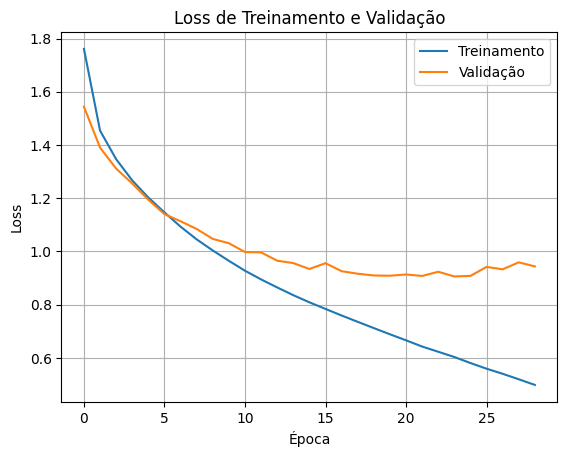

In [18]:
plotLoss(train_losses, val_losses)

In [19]:
labels, predictions = makePredictions(model2, test_loader)

scores = get_scores(labels, predictions)
print("Scores of your model\n", scores)

Scores of your model
 {'accuracy': 0.6932, 'balanced_accuracy': 0.6931999999999999, 'precision': 0.6954373416965544, 'recall': 0.6932, 'f1_score': 0.6913819540778005}


## Experiment 3

Adicionar dropout para diminuir o overfitting

In [12]:
learning_rate = 0.0001
num_epochs = 50
batch_size = 32
patience = 5

train_loader, val_loader, test_loader = makeLoaders(batch_size)

In [14]:
config2 = {
    'conv_layers': [
        (32, 3, 1, 1, True),
        (64, 3, 1, 1, True),
        (128, 3, 1, 1, True)
    ],
    'pool_kernel_size': 2,
    'pool_stride': 2,
    'fc_layers': [
        (120, 0.2),
        (84, 0.2)
    ],
    'output_size': 10
}

# Criando o modelo
model3 = FlexibleCNN(config2)

optimizer = optim.Adam(model3.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [15]:
trained_CNN, train_losses, val_losses = train_model(model3,
                                                    train_loader,
                                                    val_loader,
                                                    criterion,
                                                    optimizer,
                                                    device,
                                                    num_epochs,
                                                    patience)

  0%|          | 0/50 [00:16<?, ?it/s]

Epoch 1/50, Step 1000/1250, Loss: 1.8398


  2%|▏         | 1/50 [00:23<19:17, 23.62s/it]

Epoch 1 completed. Train Loss: 1.9058 | Val Loss: 1.6332


  2%|▏         | 1/50 [00:38<19:17, 23.62s/it]

Epoch 2/50, Step 1000/1250, Loss: 1.5035


  4%|▍         | 2/50 [00:46<18:24, 23.02s/it]

Epoch 2 completed. Train Loss: 1.6013 | Val Loss: 1.4581


  4%|▍         | 2/50 [00:48<19:16, 24.09s/it]


KeyboardInterrupt: 

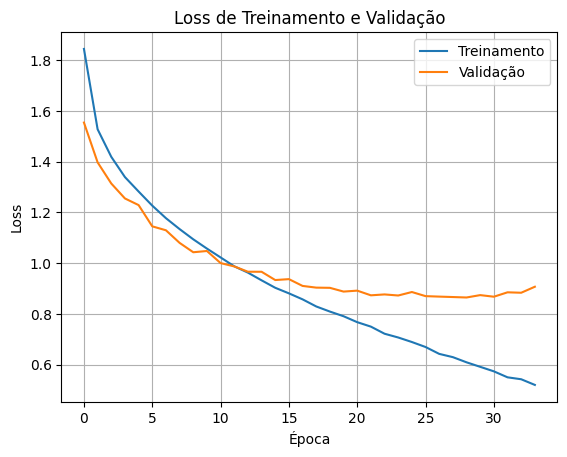

In [28]:
plotLoss(train_losses, val_losses)

In [29]:
labels, predictions = makePredictions(model2, test_loader)

scores = get_scores(labels, predictions)
print("Scores of your model\n", scores)

Scores of your model
 {'accuracy': 0.6932, 'balanced_accuracy': 0.6931999999999999, 'precision': 0.6954373416965544, 'recall': 0.6932, 'f1_score': 0.6913819540778005}


## Experiment: aumentar uma camada convolucional

In [16]:
learning_rate = 0.0001
num_epochs = 50
batch_size = 32
patience = 5

train_loader, val_loader, test_loader = makeLoaders(batch_size)

In [23]:
config3 = {
    'conv_layers': [
        (32, 3, 1, 1, True),
        (64, 3, 1, 1, True),
        (120, 3, 1, 1, True)
    ],
    'pool_kernel_size': 2,
    'pool_stride': 2,
    'fc_layers': [
        (120, 0.2),
        (84, 0.2)
    ],
    'output_size': 10
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Criando o modelo
model_3_conv_layers = FlexibleCNN(config3).to(device)

optimizer = optim.Adam(model_3_conv_layers.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [24]:
trained_CNN, train_losses, val_losses = train_model(model_3_conv_layers,
                                                    train_loader,
                                                    val_loader,
                                                    criterion,
                                                    optimizer,
                                                    device,
                                                    num_epochs,
                                                    patience)

  0%|          | 0/50 [00:13<?, ?it/s]

Epoch 1/50, Step 1000/1250, Loss: 1.7091


  2%|▏         | 1/50 [00:20<16:52, 20.66s/it]

Epoch 1 completed. Train Loss: 1.8899 | Val Loss: 1.6140


  2%|▏         | 1/50 [00:34<16:52, 20.66s/it]

Epoch 2/50, Step 1000/1250, Loss: 1.5430


  4%|▍         | 2/50 [00:41<16:30, 20.64s/it]

Epoch 2 completed. Train Loss: 1.6020 | Val Loss: 1.4849


  4%|▍         | 2/50 [00:55<16:30, 20.64s/it]

Epoch 3/50, Step 1000/1250, Loss: 1.4012


  6%|▌         | 3/50 [01:01<16:03, 20.51s/it]

Epoch 3 completed. Train Loss: 1.4830 | Val Loss: 1.3699


  6%|▌         | 3/50 [01:13<16:03, 20.51s/it]

Epoch 4/50, Step 1000/1250, Loss: 1.5262


  8%|▊         | 4/50 [01:18<14:37, 19.08s/it]

Epoch 4 completed. Train Loss: 1.4053 | Val Loss: 1.3012


  8%|▊         | 4/50 [01:29<14:37, 19.08s/it]

Epoch 5/50, Step 1000/1250, Loss: 1.3053


 10%|█         | 5/50 [01:34<13:27, 17.95s/it]

Epoch 5 completed. Train Loss: 1.3331 | Val Loss: 1.2410


 10%|█         | 5/50 [01:45<13:27, 17.95s/it]

Epoch 6/50, Step 1000/1250, Loss: 1.2456


 12%|█▏        | 6/50 [01:50<12:46, 17.43s/it]

Epoch 6 completed. Train Loss: 1.2714 | Val Loss: 1.2078


 12%|█▏        | 6/50 [02:01<12:46, 17.43s/it]

Epoch 7/50, Step 1000/1250, Loss: 1.0604


 14%|█▍        | 7/50 [02:07<12:11, 17.01s/it]

Epoch 7 completed. Train Loss: 1.2179 | Val Loss: 1.1392


 14%|█▍        | 7/50 [02:17<12:11, 17.01s/it]

Epoch 8/50, Step 1000/1250, Loss: 0.8562


 16%|█▌        | 8/50 [02:23<11:40, 16.68s/it]

Epoch 8 completed. Train Loss: 1.1693 | Val Loss: 1.1094


 16%|█▌        | 8/50 [02:33<11:40, 16.68s/it]

Epoch 9/50, Step 1000/1250, Loss: 1.2856


 18%|█▊        | 9/50 [02:38<11:12, 16.40s/it]

Epoch 9 completed. Train Loss: 1.1237 | Val Loss: 1.0700


 18%|█▊        | 9/50 [02:49<11:12, 16.40s/it]

Epoch 10/50, Step 1000/1250, Loss: 1.2547


 20%|██        | 10/50 [02:55<10:56, 16.41s/it]

Epoch 10 completed. Train Loss: 1.0839 | Val Loss: 1.0494


 20%|██        | 10/50 [03:06<10:56, 16.41s/it]

Epoch 11/50, Step 1000/1250, Loss: 0.9705


 22%|██▏       | 11/50 [03:11<10:41, 16.45s/it]

Epoch 11 completed. Train Loss: 1.0375 | Val Loss: 1.0207


 22%|██▏       | 11/50 [03:22<10:41, 16.45s/it]

Epoch 12/50, Step 1000/1250, Loss: 1.2661


 24%|██▍       | 12/50 [03:28<10:26, 16.48s/it]

Epoch 12 completed. Train Loss: 1.0011 | Val Loss: 0.9799


 24%|██▍       | 12/50 [03:39<10:26, 16.48s/it]

Epoch 13/50, Step 1000/1250, Loss: 1.3518


 26%|██▌       | 13/50 [03:45<10:12, 16.56s/it]

Epoch 13 completed. Train Loss: 0.9638 | Val Loss: 0.9677


 26%|██▌       | 13/50 [03:56<10:12, 16.56s/it]

Epoch 14/50, Step 1000/1250, Loss: 0.7915


 28%|██▊       | 14/50 [04:01<09:56, 16.56s/it]

Epoch 14 completed. Train Loss: 0.9346 | Val Loss: 0.9474


 28%|██▊       | 14/50 [04:12<09:56, 16.56s/it]

Epoch 15/50, Step 1000/1250, Loss: 1.0405


 30%|███       | 15/50 [04:18<09:40, 16.59s/it]

Epoch 15 completed. Train Loss: 0.9003 | Val Loss: 0.9211


 30%|███       | 15/50 [04:29<09:40, 16.59s/it]

Epoch 16/50, Step 1000/1250, Loss: 0.9412


 32%|███▏      | 16/50 [04:34<09:23, 16.57s/it]

Epoch 16 completed. Train Loss: 0.8744 | Val Loss: 0.9010


 32%|███▏      | 16/50 [04:45<09:23, 16.57s/it]

Epoch 17/50, Step 1000/1250, Loss: 0.6707


 34%|███▍      | 17/50 [04:51<09:07, 16.59s/it]

Epoch 17 completed. Train Loss: 0.8449 | Val Loss: 0.8989


 34%|███▍      | 17/50 [05:02<09:07, 16.59s/it]

Epoch 18/50, Step 1000/1250, Loss: 1.0410


 36%|███▌      | 18/50 [05:08<08:51, 16.61s/it]

Epoch 18 completed. Train Loss: 0.8180 | Val Loss: 0.8555


 36%|███▌      | 18/50 [05:19<08:51, 16.61s/it]

Epoch 19/50, Step 1000/1250, Loss: 0.7399


 38%|███▊      | 19/50 [05:25<08:39, 16.77s/it]

Epoch 19 completed. Train Loss: 0.7917 | Val Loss: 0.8642


 38%|███▊      | 19/50 [05:36<08:39, 16.77s/it]

Epoch 20/50, Step 1000/1250, Loss: 0.6545


 40%|████      | 20/50 [05:41<08:22, 16.77s/it]

Epoch 20 completed. Train Loss: 0.7680 | Val Loss: 0.8740


 40%|████      | 20/50 [05:53<08:22, 16.77s/it]

Epoch 21/50, Step 1000/1250, Loss: 0.6152


 42%|████▏     | 21/50 [05:58<08:05, 16.74s/it]

Epoch 21 completed. Train Loss: 0.7397 | Val Loss: 0.8392


 42%|████▏     | 21/50 [06:09<08:05, 16.74s/it]

Epoch 22/50, Step 1000/1250, Loss: 1.0784


 44%|████▍     | 22/50 [06:15<07:48, 16.73s/it]

Epoch 22 completed. Train Loss: 0.7194 | Val Loss: 0.8370


 44%|████▍     | 22/50 [06:26<07:48, 16.73s/it]

Epoch 23/50, Step 1000/1250, Loss: 0.5248


 46%|████▌     | 23/50 [06:31<07:29, 16.64s/it]

Epoch 23 completed. Train Loss: 0.6986 | Val Loss: 0.8149


 46%|████▌     | 23/50 [06:42<07:29, 16.64s/it]

Epoch 24/50, Step 1000/1250, Loss: 0.5122


 48%|████▊     | 24/50 [06:48<07:12, 16.62s/it]

Epoch 24 completed. Train Loss: 0.6746 | Val Loss: 0.8040


 48%|████▊     | 24/50 [06:59<07:12, 16.62s/it]

Epoch 25/50, Step 1000/1250, Loss: 0.6586


 50%|█████     | 25/50 [07:04<06:53, 16.55s/it]

Epoch 25 completed. Train Loss: 0.6552 | Val Loss: 0.7944


 50%|█████     | 25/50 [07:15<06:53, 16.55s/it]

Epoch 26/50, Step 1000/1250, Loss: 0.6592


 52%|█████▏    | 26/50 [07:21<06:36, 16.51s/it]

Epoch 26 completed. Train Loss: 0.6331 | Val Loss: 0.7948


 52%|█████▏    | 26/50 [07:32<06:36, 16.51s/it]

Epoch 27/50, Step 1000/1250, Loss: 0.5694


 54%|█████▍    | 27/50 [07:37<06:18, 16.44s/it]

Epoch 27 completed. Train Loss: 0.6170 | Val Loss: 0.8086


 54%|█████▍    | 27/50 [07:48<06:18, 16.44s/it]

Epoch 28/50, Step 1000/1250, Loss: 0.6380


 56%|█████▌    | 28/50 [07:53<06:00, 16.38s/it]

Epoch 28 completed. Train Loss: 0.5916 | Val Loss: 0.7839


 56%|█████▌    | 28/50 [08:04<06:00, 16.38s/it]

Epoch 29/50, Step 1000/1250, Loss: 0.3366


 58%|█████▊    | 29/50 [08:10<05:44, 16.43s/it]

Epoch 29 completed. Train Loss: 0.5753 | Val Loss: 0.7943


 58%|█████▊    | 29/50 [08:21<05:44, 16.43s/it]

Epoch 30/50, Step 1000/1250, Loss: 0.6386


 60%|██████    | 30/50 [08:26<05:28, 16.40s/it]

Epoch 30 completed. Train Loss: 0.5513 | Val Loss: 0.8005


 60%|██████    | 30/50 [08:37<05:28, 16.40s/it]

Epoch 31/50, Step 1000/1250, Loss: 0.7213


 62%|██████▏   | 31/50 [08:43<05:11, 16.42s/it]

Epoch 31 completed. Train Loss: 0.5369 | Val Loss: 0.7994


 62%|██████▏   | 31/50 [08:54<05:11, 16.42s/it]

Epoch 32/50, Step 1000/1250, Loss: 0.5908


 64%|██████▍   | 32/50 [08:59<04:56, 16.45s/it]

Epoch 32 completed. Train Loss: 0.5158 | Val Loss: 0.8166


 64%|██████▍   | 32/50 [09:10<04:56, 16.45s/it]

Epoch 33/50, Step 1000/1250, Loss: 0.3090


 64%|██████▍   | 32/50 [09:16<05:12, 17.38s/it]

Epoch 33 completed. Train Loss: 0.4972 | Val Loss: 0.8023
Early stopping at epoch 33


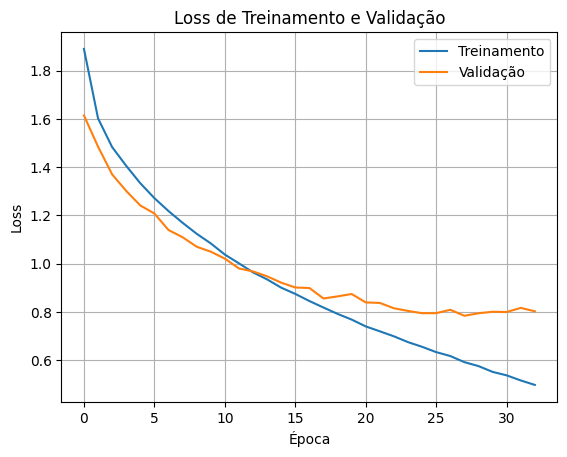

In [25]:
plotLoss(train_losses, val_losses)

In [26]:
labels, predictions = makePredictions(model_3_conv_layers, test_loader)

scores = get_scores(labels, predictions)
print("Scores of your model\n", scores)

Scores of your model
 {'accuracy': 0.74, 'balanced_accuracy': 0.74, 'precision': 0.7440000099510472, 'recall': 0.74, 'f1_score': 0.7406544420257327}


## Experiment: aumentar uma camada totalmente conectada

In [28]:
config4 = {
    'conv_layers': [
        (32, 3, 1, 1),
        (64, 3, 1, 1),
        (120, 3, 1, 1)
    ],
    'pool_kernel_size': 2,
    'pool_stride': 2,
    'fc_layers': [
        (256, 0.2),
        (128, 0.2),
        (64, 0.2)
    ],
    'output_size': 10
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Criando o modelo
model_3_conv_layers2 = FlexibleCNN(config4).to(device)

optimizer = optim.Adam(model_3_conv_layers2.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [32]:
trained_CNN, train_losses, val_losses = train_model(model_3_conv_layers2,
                                                    train_loader,
                                                    val_loader,
                                                    criterion,
                                                    optimizer,
                                                    device,
                                                    num_epochs,
                                                    patience)

NameError: name 'model_3_conv_layers2' is not defined

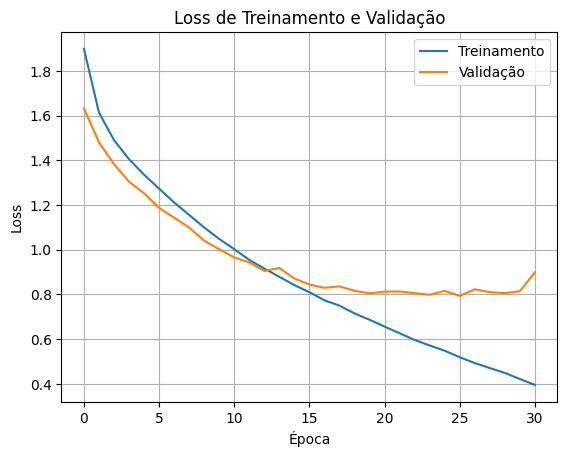

In [30]:
plotLoss(train_losses, val_losses)

In [32]:
labels, predictions = makePredictions(model_3_conv_layers2, test_loader)

scores = get_scores(labels, predictions)
print("Scores of your model\n", scores)

Scores of your model
 {'accuracy': 0.727, 'balanced_accuracy': 0.7269999999999999, 'precision': 0.7367266834219764, 'recall': 0.727, 'f1_score': 0.7276943242436139}


## Experiment: pool após 2 convoluções

arquitetura para o experimento: 
- 2 convoluções 3x3
- max pool 2x2
- 2 convoluções 3x3
- max pool 2x2

In [ ]:
learning_rate = 0.0001
num_epochs = 50
batch_size = 32
patience = 5

train_loader, val_loader, test_loader = makeLoaders(batch_size)

In [39]:
config_2convs_1pool  = {
    'conv_layers': [
        (32, 3, 1, 1, False),   # conv apenas
        (64, 3, 1, 1, True),  # conv + pool
        (128, 3, 1, 1, False),  # conv apenas
        (256, 3, 1, 1, True)  # conv + pool
    ],
    'pool_kernel_size': 2,
    'pool_stride': 2,
    'fc_layers': [
        (120, 0.4),
        (84, 0.4)
    ],
    'output_size': 10
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Criando o modelo
model_2convs_1pool = FlexibleCNN(config_2convs_1pool).to(device)

optimizer = optim.Adam(model_2convs_1pool.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [40]:
trained_CNN, train_losses, val_losses = train_model(model_2convs_1pool,
                                                    train_loader,
                                                    val_loader,
                                                    criterion,
                                                    optimizer,
                                                    device,
                                                    num_epochs,
                                                    patience)

  0%|          | 0/50 [00:15<?, ?it/s]

Epoch 1/50, Step 1000/1250, Loss: 1.7246


  2%|▏         | 1/50 [00:22<18:27, 22.59s/it]

Epoch 1 completed. Train Loss: 1.9336 | Val Loss: 1.5782


  2%|▏         | 1/50 [00:37<18:27, 22.59s/it]

Epoch 2/50, Step 1000/1250, Loss: 1.4864


  4%|▍         | 2/50 [00:44<17:58, 22.47s/it]

Epoch 2 completed. Train Loss: 1.6266 | Val Loss: 1.4273


  4%|▍         | 2/50 [00:59<17:58, 22.47s/it]

Epoch 3/50, Step 1000/1250, Loss: 1.5623


  6%|▌         | 3/50 [01:06<17:25, 22.23s/it]

Epoch 3 completed. Train Loss: 1.4867 | Val Loss: 1.2765


  6%|▌         | 3/50 [01:22<17:25, 22.23s/it]

Epoch 4/50, Step 1000/1250, Loss: 1.5643


  8%|▊         | 4/50 [01:29<17:04, 22.27s/it]

Epoch 4 completed. Train Loss: 1.3870 | Val Loss: 1.1907


  8%|▊         | 4/50 [01:44<17:04, 22.27s/it]

Epoch 5/50, Step 1000/1250, Loss: 1.3687


 10%|█         | 5/50 [01:51<16:41, 22.25s/it]

Epoch 5 completed. Train Loss: 1.2907 | Val Loss: 1.1171


 10%|█         | 5/50 [02:06<16:41, 22.25s/it]

Epoch 6/50, Step 1000/1250, Loss: 1.3689


 12%|█▏        | 6/50 [02:14<16:25, 22.40s/it]

Epoch 6 completed. Train Loss: 1.2223 | Val Loss: 1.0641


 12%|█▏        | 6/50 [02:29<16:25, 22.40s/it]

Epoch 7/50, Step 1000/1250, Loss: 1.3618


 14%|█▍        | 7/50 [02:36<16:03, 22.42s/it]

Epoch 7 completed. Train Loss: 1.1596 | Val Loss: 1.0121


 14%|█▍        | 7/50 [02:51<16:03, 22.42s/it]

Epoch 8/50, Step 1000/1250, Loss: 1.4125


 16%|█▌        | 8/50 [02:58<15:37, 22.32s/it]

Epoch 8 completed. Train Loss: 1.0953 | Val Loss: 0.9615


 16%|█▌        | 8/50 [03:12<15:37, 22.32s/it]

Epoch 9/50, Step 1000/1250, Loss: 1.1313


 18%|█▊        | 9/50 [03:19<14:55, 21.84s/it]

Epoch 9 completed. Train Loss: 1.0451 | Val Loss: 0.9358


 18%|█▊        | 9/50 [03:33<14:55, 21.84s/it]

Epoch 10/50, Step 1000/1250, Loss: 1.0567


 20%|██        | 10/50 [03:40<14:20, 21.51s/it]

Epoch 10 completed. Train Loss: 1.0023 | Val Loss: 0.9457


 20%|██        | 10/50 [03:54<14:20, 21.51s/it]

Epoch 11/50, Step 1000/1250, Loss: 1.0384


 22%|██▏       | 11/50 [04:01<13:54, 21.40s/it]

Epoch 11 completed. Train Loss: 0.9605 | Val Loss: 0.8817


 22%|██▏       | 11/50 [04:15<13:54, 21.40s/it]

Epoch 12/50, Step 1000/1250, Loss: 0.6780


 24%|██▍       | 12/50 [04:22<13:29, 21.30s/it]

Epoch 12 completed. Train Loss: 0.9263 | Val Loss: 0.8824


 24%|██▍       | 12/50 [04:36<13:29, 21.30s/it]

Epoch 13/50, Step 1000/1250, Loss: 0.8113


 26%|██▌       | 13/50 [04:43<13:05, 21.22s/it]

Epoch 13 completed. Train Loss: 0.8834 | Val Loss: 0.8380


 26%|██▌       | 13/50 [04:57<13:05, 21.22s/it]

Epoch 14/50, Step 1000/1250, Loss: 0.8863


 28%|██▊       | 14/50 [05:04<12:39, 21.10s/it]

Epoch 14 completed. Train Loss: 0.8397 | Val Loss: 0.8348


 28%|██▊       | 14/50 [05:18<12:39, 21.10s/it]

Epoch 15/50, Step 1000/1250, Loss: 1.0624


 30%|███       | 15/50 [05:25<12:15, 21.00s/it]

Epoch 15 completed. Train Loss: 0.8072 | Val Loss: 0.8018


 30%|███       | 15/50 [05:39<12:15, 21.00s/it]

Epoch 16/50, Step 1000/1250, Loss: 0.7019


 32%|███▏      | 16/50 [05:45<11:51, 20.93s/it]

Epoch 16 completed. Train Loss: 0.7761 | Val Loss: 0.8113


 32%|███▏      | 16/50 [05:59<11:51, 20.93s/it]

Epoch 17/50, Step 1000/1250, Loss: 0.7419


 34%|███▍      | 17/50 [06:06<11:28, 20.86s/it]

Epoch 17 completed. Train Loss: 0.7306 | Val Loss: 0.7896


 34%|███▍      | 17/50 [06:20<11:28, 20.86s/it]

Epoch 18/50, Step 1000/1250, Loss: 0.5320


 36%|███▌      | 18/50 [06:27<11:05, 20.81s/it]

Epoch 18 completed. Train Loss: 0.6922 | Val Loss: 0.7837


 36%|███▌      | 18/50 [06:41<11:05, 20.81s/it]

Epoch 19/50, Step 1000/1250, Loss: 0.4016


 38%|███▊      | 19/50 [06:47<10:41, 20.69s/it]

Epoch 19 completed. Train Loss: 0.6715 | Val Loss: 0.7654


 38%|███▊      | 19/50 [07:01<10:41, 20.69s/it]

Epoch 20/50, Step 1000/1250, Loss: 0.4248


 40%|████      | 20/50 [07:08<10:18, 20.61s/it]

Epoch 20 completed. Train Loss: 0.6375 | Val Loss: 0.7662


 40%|████      | 20/50 [07:22<10:18, 20.61s/it]

Epoch 21/50, Step 1000/1250, Loss: 0.8480


 42%|████▏     | 21/50 [07:28<09:59, 20.67s/it]

Epoch 21 completed. Train Loss: 0.6035 | Val Loss: 0.7680


 42%|████▏     | 21/50 [07:42<09:59, 20.67s/it]

Epoch 22/50, Step 1000/1250, Loss: 0.6002


 44%|████▍     | 22/50 [07:49<09:37, 20.61s/it]

Epoch 22 completed. Train Loss: 0.5672 | Val Loss: 0.7651


 44%|████▍     | 22/50 [08:03<09:37, 20.61s/it]

Epoch 23/50, Step 1000/1250, Loss: 0.4874


 46%|████▌     | 23/50 [08:10<09:17, 20.64s/it]

Epoch 23 completed. Train Loss: 0.5297 | Val Loss: 0.8029


 46%|████▌     | 23/50 [08:24<09:17, 20.64s/it]

Epoch 24/50, Step 1000/1250, Loss: 0.6230


 48%|████▊     | 24/50 [08:30<08:57, 20.66s/it]

Epoch 24 completed. Train Loss: 0.5055 | Val Loss: 0.7775


 48%|████▊     | 24/50 [08:44<08:57, 20.66s/it]

Epoch 25/50, Step 1000/1250, Loss: 0.4960


 50%|█████     | 25/50 [08:51<08:34, 20.57s/it]

Epoch 25 completed. Train Loss: 0.4795 | Val Loss: 0.7901


 50%|█████     | 25/50 [09:05<08:34, 20.57s/it]

Epoch 26/50, Step 1000/1250, Loss: 0.3222


 52%|█████▏    | 26/50 [09:11<08:14, 20.59s/it]

Epoch 26 completed. Train Loss: 0.4484 | Val Loss: 0.7988


 52%|█████▏    | 26/50 [09:25<08:14, 20.59s/it]

Epoch 27/50, Step 1000/1250, Loss: 0.4220


 52%|█████▏    | 26/50 [09:32<08:48, 22.02s/it]

Epoch 27 completed. Train Loss: 0.4213 | Val Loss: 0.8134
Early stopping at epoch 27


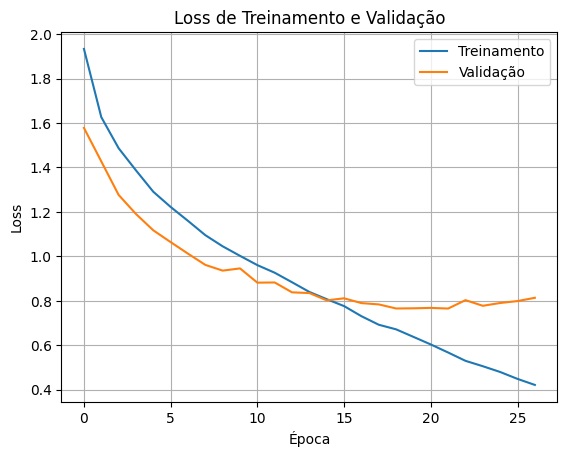

In [42]:
plotLoss(train_losses, val_losses)

In [43]:
labels, predictions = makePredictions(trained_CNN, test_loader)

scores = get_scores(labels, predictions)
print("Scores of your model\n", scores)

Scores of your model
 {'accuracy': 0.7588, 'balanced_accuracy': 0.7587999999999999, 'precision': 0.7580833376359049, 'recall': 0.7588, 'f1_score': 0.7574479797487332}


## Experiment: usando data augmentation

Mesma arquitetura do experimento anterior, porém com as seguintes mudanças:
- Usando o conjunto de treinamento modificado com data augmentation
- batch size de 64

In [18]:
learning_rate = 0.0001
num_epochs = 70
batch_size = 64
patience = 5

In [ ]:
train_loader_aug = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [20]:
config_2convs_1pool  = {
    'conv_layers': [
        (32, 3, 1, 1, False),   # conv apenas
        (64, 3, 1, 1, True),  # conv + pool
        (128, 3, 1, 1, False),  # conv apenas
        (256, 3, 1, 1, True)  # conv + pool
    ],
    'pool_kernel_size': 2,
    'pool_stride': 2,
    'fc_layers': [
        (120, 0.4),
        (84, 0.4)
    ],
    'output_size': 10
}

# Criando o modelo
model_2convs_1pool = FlexibleCNN(config_2convs_1pool).to(device)

optimizer = optim.Adam(model_2convs_1pool.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [21]:
trained_CNN, train_losses, val_losses = train_model(model_2convs_1pool,
                                                    train_loader,
                                                    val_loader,
                                                    criterion,
                                                    optimizer,
                                                    device,
                                                    num_epochs,
                                                    patience)

  1%|▏         | 1/70 [00:28<32:17, 28.08s/it]

Epoch 1 completed. Train Loss: 2.0500 | Val Loss: 1.7451


  3%|▎         | 2/70 [00:54<30:57, 27.31s/it]

Epoch 2 completed. Train Loss: 1.8179 | Val Loss: 1.5715


  4%|▍         | 3/70 [01:21<30:19, 27.15s/it]

Epoch 3 completed. Train Loss: 1.7004 | Val Loss: 1.4581


  6%|▌         | 4/70 [01:48<29:38, 26.95s/it]

Epoch 4 completed. Train Loss: 1.6206 | Val Loss: 1.3900


  7%|▋         | 5/70 [02:15<29:04, 26.84s/it]

Epoch 5 completed. Train Loss: 1.5710 | Val Loss: 1.3456


  9%|▊         | 6/70 [02:41<28:27, 26.68s/it]

Epoch 6 completed. Train Loss: 1.5254 | Val Loss: 1.3168


 10%|█         | 7/70 [03:08<27:59, 26.66s/it]

Epoch 7 completed. Train Loss: 1.4805 | Val Loss: 1.2865


 11%|█▏        | 8/70 [03:34<27:27, 26.57s/it]

Epoch 8 completed. Train Loss: 1.4436 | Val Loss: 1.2467


 13%|█▎        | 9/70 [04:01<27:01, 26.58s/it]

Epoch 9 completed. Train Loss: 1.4097 | Val Loss: 1.2123


 14%|█▍        | 10/70 [04:27<26:29, 26.49s/it]

Epoch 10 completed. Train Loss: 1.3772 | Val Loss: 1.1521


 16%|█▌        | 11/70 [04:53<25:59, 26.43s/it]

Epoch 11 completed. Train Loss: 1.3467 | Val Loss: 1.1253


 17%|█▋        | 12/70 [05:20<25:32, 26.42s/it]

Epoch 12 completed. Train Loss: 1.3054 | Val Loss: 1.0784


 19%|█▊        | 13/70 [05:46<25:03, 26.38s/it]

Epoch 13 completed. Train Loss: 1.2702 | Val Loss: 1.0430


 20%|██        | 14/70 [06:12<24:37, 26.38s/it]

Epoch 14 completed. Train Loss: 1.2452 | Val Loss: 1.0125


 21%|██▏       | 15/70 [06:39<24:11, 26.40s/it]

Epoch 15 completed. Train Loss: 1.2154 | Val Loss: 0.9888


 23%|██▎       | 16/70 [07:05<23:50, 26.49s/it]

Epoch 16 completed. Train Loss: 1.1863 | Val Loss: 0.9837


 24%|██▍       | 17/70 [07:32<23:25, 26.52s/it]

Epoch 17 completed. Train Loss: 1.1646 | Val Loss: 0.9578


 26%|██▌       | 18/70 [07:58<22:55, 26.45s/it]

Epoch 18 completed. Train Loss: 1.1395 | Val Loss: 0.9480


 27%|██▋       | 19/70 [08:25<22:27, 26.43s/it]

Epoch 19 completed. Train Loss: 1.1184 | Val Loss: 0.8998


 29%|██▊       | 20/70 [08:51<22:03, 26.48s/it]

Epoch 20 completed. Train Loss: 1.0953 | Val Loss: 0.9000


 30%|███       | 21/70 [09:18<21:37, 26.49s/it]

Epoch 21 completed. Train Loss: 1.0779 | Val Loss: 0.8622


 31%|███▏      | 22/70 [09:44<21:13, 26.53s/it]

Epoch 22 completed. Train Loss: 1.0569 | Val Loss: 0.8829


 33%|███▎      | 23/70 [10:11<20:51, 26.63s/it]

Epoch 23 completed. Train Loss: 1.0295 | Val Loss: 0.8340


 34%|███▍      | 24/70 [10:38<20:26, 26.67s/it]

Epoch 24 completed. Train Loss: 1.0224 | Val Loss: 0.8257


 36%|███▌      | 25/70 [11:04<19:56, 26.59s/it]

Epoch 25 completed. Train Loss: 0.9994 | Val Loss: 0.8177


 37%|███▋      | 26/70 [11:31<19:26, 26.51s/it]

Epoch 26 completed. Train Loss: 0.9882 | Val Loss: 0.8121


 39%|███▊      | 27/70 [11:57<18:56, 26.44s/it]

Epoch 27 completed. Train Loss: 0.9714 | Val Loss: 0.8079


 40%|████      | 28/70 [12:24<18:32, 26.49s/it]

Epoch 28 completed. Train Loss: 0.9586 | Val Loss: 0.7753


 41%|████▏     | 29/70 [12:50<18:06, 26.49s/it]

Epoch 29 completed. Train Loss: 0.9434 | Val Loss: 0.7542


 43%|████▎     | 30/70 [13:16<17:37, 26.43s/it]

Epoch 30 completed. Train Loss: 0.9284 | Val Loss: 0.7621


 44%|████▍     | 31/70 [13:43<17:12, 26.47s/it]

Epoch 31 completed. Train Loss: 0.9173 | Val Loss: 0.7659


 46%|████▌     | 32/70 [14:09<16:46, 26.48s/it]

Epoch 32 completed. Train Loss: 0.8970 | Val Loss: 0.7569


 47%|████▋     | 33/70 [14:36<16:21, 26.52s/it]

Epoch 33 completed. Train Loss: 0.8897 | Val Loss: 0.7276


 49%|████▊     | 34/70 [15:03<15:54, 26.52s/it]

Epoch 34 completed. Train Loss: 0.8691 | Val Loss: 0.7074


 50%|█████     | 35/70 [15:29<15:30, 26.58s/it]

Epoch 35 completed. Train Loss: 0.8637 | Val Loss: 0.7095


 51%|█████▏    | 36/70 [15:56<15:03, 26.58s/it]

Epoch 36 completed. Train Loss: 0.8462 | Val Loss: 0.6950


 53%|█████▎    | 37/70 [16:22<14:35, 26.52s/it]

Epoch 37 completed. Train Loss: 0.8374 | Val Loss: 0.6803


 54%|█████▍    | 38/70 [16:49<14:09, 26.55s/it]

Epoch 38 completed. Train Loss: 0.8268 | Val Loss: 0.6765


 56%|█████▌    | 39/70 [17:15<13:41, 26.51s/it]

Epoch 39 completed. Train Loss: 0.8170 | Val Loss: 0.6722


 57%|█████▋    | 40/70 [17:42<13:16, 26.55s/it]

Epoch 40 completed. Train Loss: 0.7967 | Val Loss: 0.6652


 59%|█████▊    | 41/70 [18:09<12:50, 26.57s/it]

Epoch 41 completed. Train Loss: 0.7861 | Val Loss: 0.6718


 60%|██████    | 42/70 [18:35<12:21, 26.49s/it]

Epoch 42 completed. Train Loss: 0.7750 | Val Loss: 0.6350


 61%|██████▏   | 43/70 [19:01<11:54, 26.45s/it]

Epoch 43 completed. Train Loss: 0.7662 | Val Loss: 0.6321


 63%|██████▎   | 44/70 [19:28<11:29, 26.51s/it]

Epoch 44 completed. Train Loss: 0.7569 | Val Loss: 0.6294


 64%|██████▍   | 45/70 [19:54<11:02, 26.49s/it]

Epoch 45 completed. Train Loss: 0.7480 | Val Loss: 0.6354


 66%|██████▌   | 46/70 [20:21<10:36, 26.54s/it]

Epoch 46 completed. Train Loss: 0.7346 | Val Loss: 0.6374


 67%|██████▋   | 47/70 [20:48<10:12, 26.63s/it]

Epoch 47 completed. Train Loss: 0.7283 | Val Loss: 0.6205


 69%|██████▊   | 48/70 [21:14<09:43, 26.53s/it]

Epoch 48 completed. Train Loss: 0.7188 | Val Loss: 0.5993


 70%|███████   | 49/70 [21:41<09:16, 26.51s/it]

Epoch 49 completed. Train Loss: 0.7022 | Val Loss: 0.6315


 71%|███████▏  | 50/70 [22:07<08:50, 26.54s/it]

Epoch 50 completed. Train Loss: 0.7005 | Val Loss: 0.6007


 73%|███████▎  | 51/70 [22:34<08:25, 26.60s/it]

Epoch 51 completed. Train Loss: 0.6909 | Val Loss: 0.5963


 74%|███████▍  | 52/70 [23:01<07:59, 26.63s/it]

Epoch 52 completed. Train Loss: 0.6842 | Val Loss: 0.5899


 76%|███████▌  | 53/70 [23:27<07:32, 26.62s/it]

Epoch 53 completed. Train Loss: 0.6699 | Val Loss: 0.5808


 77%|███████▋  | 54/70 [23:54<07:05, 26.59s/it]

Epoch 54 completed. Train Loss: 0.6664 | Val Loss: 0.5960


 79%|███████▊  | 55/70 [24:20<06:39, 26.63s/it]

Epoch 55 completed. Train Loss: 0.6582 | Val Loss: 0.5640


 80%|████████  | 56/70 [24:47<06:12, 26.61s/it]

Epoch 56 completed. Train Loss: 0.6521 | Val Loss: 0.5563


 81%|████████▏ | 57/70 [25:14<05:46, 26.65s/it]

Epoch 57 completed. Train Loss: 0.6414 | Val Loss: 0.5460


 83%|████████▎ | 58/70 [25:40<05:19, 26.60s/it]

Epoch 58 completed. Train Loss: 0.6376 | Val Loss: 0.6052


 84%|████████▍ | 59/70 [26:07<04:52, 26.60s/it]

Epoch 59 completed. Train Loss: 0.6294 | Val Loss: 0.5522


 86%|████████▌ | 60/70 [26:33<04:26, 26.61s/it]

Epoch 60 completed. Train Loss: 0.6245 | Val Loss: 0.5548


 87%|████████▋ | 61/70 [27:00<03:59, 26.57s/it]

Epoch 61 completed. Train Loss: 0.6109 | Val Loss: 0.5516


 89%|████████▊ | 62/70 [27:26<03:32, 26.53s/it]

Epoch 62 completed. Train Loss: 0.6104 | Val Loss: 0.5401


 90%|█████████ | 63/70 [27:53<03:05, 26.51s/it]

Epoch 63 completed. Train Loss: 0.6016 | Val Loss: 0.5408


 91%|█████████▏| 64/70 [28:19<02:38, 26.47s/it]

Epoch 64 completed. Train Loss: 0.5892 | Val Loss: 0.5393


 93%|█████████▎| 65/70 [28:46<02:12, 26.56s/it]

Epoch 65 completed. Train Loss: 0.5880 | Val Loss: 0.5225


 94%|█████████▍| 66/70 [29:12<01:46, 26.55s/it]

Epoch 66 completed. Train Loss: 0.5845 | Val Loss: 0.5312


 96%|█████████▌| 67/70 [29:39<01:19, 26.53s/it]

Epoch 67 completed. Train Loss: 0.5716 | Val Loss: 0.5171


 97%|█████████▋| 68/70 [30:06<00:53, 26.63s/it]

Epoch 68 completed. Train Loss: 0.5720 | Val Loss: 0.5337


 99%|█████████▊| 69/70 [30:32<00:26, 26.57s/it]

Epoch 69 completed. Train Loss: 0.5640 | Val Loss: 0.5105


100%|██████████| 70/70 [30:59<00:00, 26.56s/it]

Epoch 70 completed. Train Loss: 0.5556 | Val Loss: 0.5259


In [26]:
torch.save(model_2convs_1pool.state_dict(), "best_model.pth")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_2convs_1pool = FlexibleCNN(config1).to(device)

model_2convs_1pool.load_state_dict(torch.load("best_model.pth", weights_only=True))

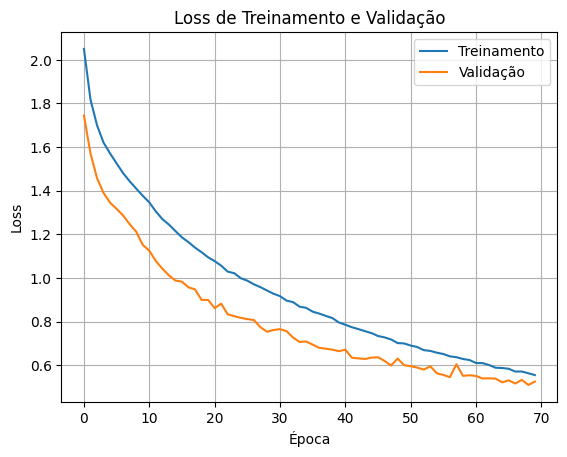

In [22]:
plotLoss(train_losses, val_losses)

In [23]:
labels, predictions = makePredictions(trained_CNN, test_loader)

scores = get_scores(labels, predictions)
print("Scores of your model\n", scores)

Scores of your model
 {'accuracy': 0.8166, 'balanced_accuracy': 0.8166, 'precision': 0.8195155539971334, 'recall': 0.8166, 'f1_score': 0.8164495870041206}


Scores of your model
 {'accuracy': 0.8166, 'balanced_accuracy': 0.8166, 'precision': 0.8195155539971334, 'recall': 0.8166, 'f1_score': 0.8164495870041206}

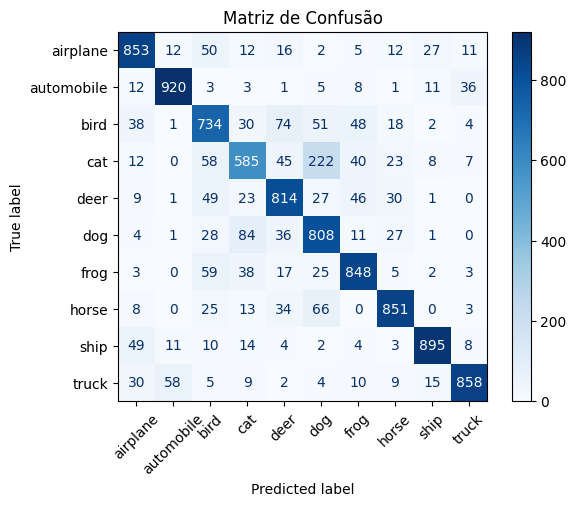

In [24]:
# Lista com nomes das classes (exemplo para CIFAR-10)
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

cm = confusion_matrix(labels, predictions)

# Plotar a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)  # pode mudar o colormap se quiser
plt.title("Matriz de Confusão")
plt.show()

## Mostrar exemplos classificados corretamente e incorretamente

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config  = {
    'conv_layers': [
        (32, 3, 1, 1, False),   # conv apenas
        (64, 3, 1, 1, True),  # conv + pool
        (128, 3, 1, 1, False),  # conv apenas
        (256, 3, 1, 1, True)  # conv + pool
    ],
    'pool_kernel_size': 2,
    'pool_stride': 2,
    'fc_layers': [
        (120, 0.4),
        (84, 0.4)
    ],
    'output_size': 10
}

best_model = FlexibleCNN(config).to(device)

best_model.load_state_dict(torch.load("best_model.pth", weights_only=True))

<All keys matched successfully>

In [27]:
# Função para desnormalizar e exibir em um subplot (sem plt.show())
def imshow_subplot(ax, img_tensor, title=""):
    img = img_tensor.cpu().numpy()
    # Desnormaliza a imagem
    img = img / 2 + 0.5
    # Converte de (C, H, W) para (H, W, C) para o matplotlib
    img = np.transpose(img, (1, 2, 0))
    
    ax.imshow(img)
    ax.set_title(title, fontsize=10)
    ax.axis('off')

Encontradas 5 imagens corretas e 5 imagens incorretas.


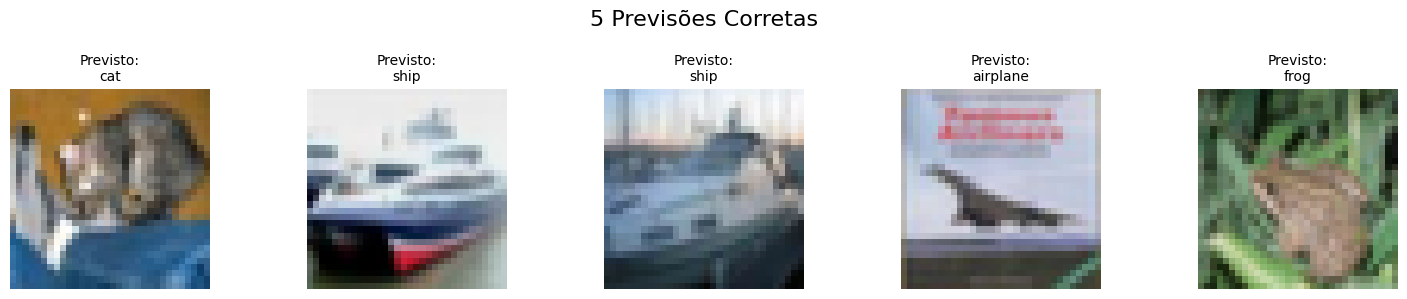

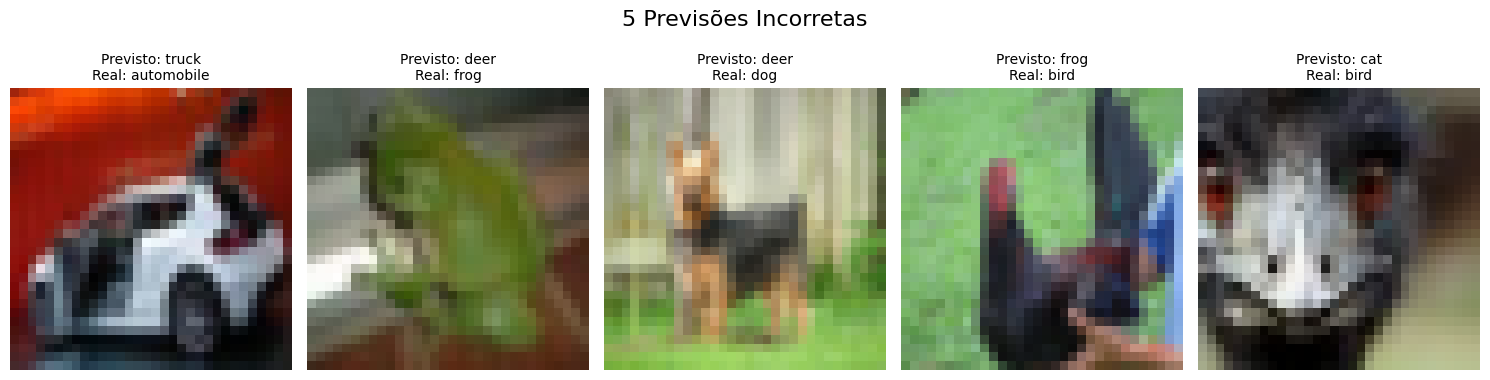

In [30]:
# Listas para armazenar os resultados
correct_images = []
correct_labels = []
incorrect_images = []
incorrect_true_labels = []
incorrect_pred_labels = []

best_model.eval()

# Loop para encontrar as imagens
with torch.no_grad():
    # Itera sobre o loader de teste
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = best_model(images)
        _, preds = torch.max(outputs, 1)

        # Itera sobre o batch
        for i in range(len(labels)):
            if preds[i] == labels[i] and len(correct_images) < 5:
                correct_images.append(images[i].cpu())
                correct_labels.append(preds[i].cpu())

            # Se a previsão está incorreta E ainda não temos 5
            elif preds[i] != labels[i] and len(incorrect_images) < 5:
                incorrect_images.append(images[i].cpu())
                incorrect_true_labels.append(labels[i].cpu())
                incorrect_pred_labels.append(preds[i].cpu())

            # Condição de parada: para quando ambas as listas estiverem cheias
            if len(correct_images) == 5 and len(incorrect_images) == 5:
                break
        
        # Para o loop principal também
        if len(correct_images) == 5 and len(incorrect_images) == 5:
            break

print(f"Encontradas {len(correct_images)} imagens corretas e {len(incorrect_images)} imagens incorretas.")


# Exibe as 5 previsões corretas
fig_correct, axes_correct = plt.subplots(1, 5, figsize=(15, 3))
fig_correct.suptitle("5 Previsões Corretas", fontsize=16)

for i, ax in enumerate(axes_correct):
    if i < len(correct_images):
        title = f"Previsto:\n{class_names[correct_labels[i].item()]}"
        imshow_subplot(ax, correct_images[i], title)
plt.tight_layout(rect=[0, 0, 1, 0.95]) # Ajusta para o super-título
plt.show()


# Exibe as 5 previsões incorretas
fig_incorrect, axes_incorrect = plt.subplots(1, 5, figsize=(15, 4)) # Um pouco mais de altura para o título duplo
fig_incorrect.suptitle("5 Previsões Incorretas", fontsize=16)

for i, ax in enumerate(axes_incorrect):
    if i < len(incorrect_images):
        title = f"Previsto: {class_names[incorrect_pred_labels[i].item()]}\nReal: {class_names[incorrect_true_labels[i].item()]}"
        imshow_subplot(ax, incorrect_images[i], title)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()